# Intepreting DLRM model with Captum

This tutorial shows how to apply a model interpretability library, Captum, to a deep learning recommender model (DLRM).
More about the DLRM achitecture and usage can be found here:
https://github.com/facebookresearch/dlrm

For our experiments we used Criteo's traffic over a period of 7 days. The dataset is also available on kaggle for download:
https://www.kaggle.com/c/criteo-display-ad-challenge
We pre-trained DLRM model using 39M Ads from Criteo dataset. From feature importance calculation perspective we used a small fraction of preprocessed data. 

In this tutorial we aim to answer the following questions:
1. Which input features are essential in predicting clicked and non-clicked Ads ?
2. What is the importance of the interaction layer ?
3. Which neurons are important for predicting `Clicked` Ads in the last fully-connected layer ?
4. How can neuron importance help us to perform model pruning. 

1st, 2nd and 3rd points are also visualized in the diagram below.

Note: Please, run this tutorial in a GPU environment. It is most probably going to fail in a CPU environment. 

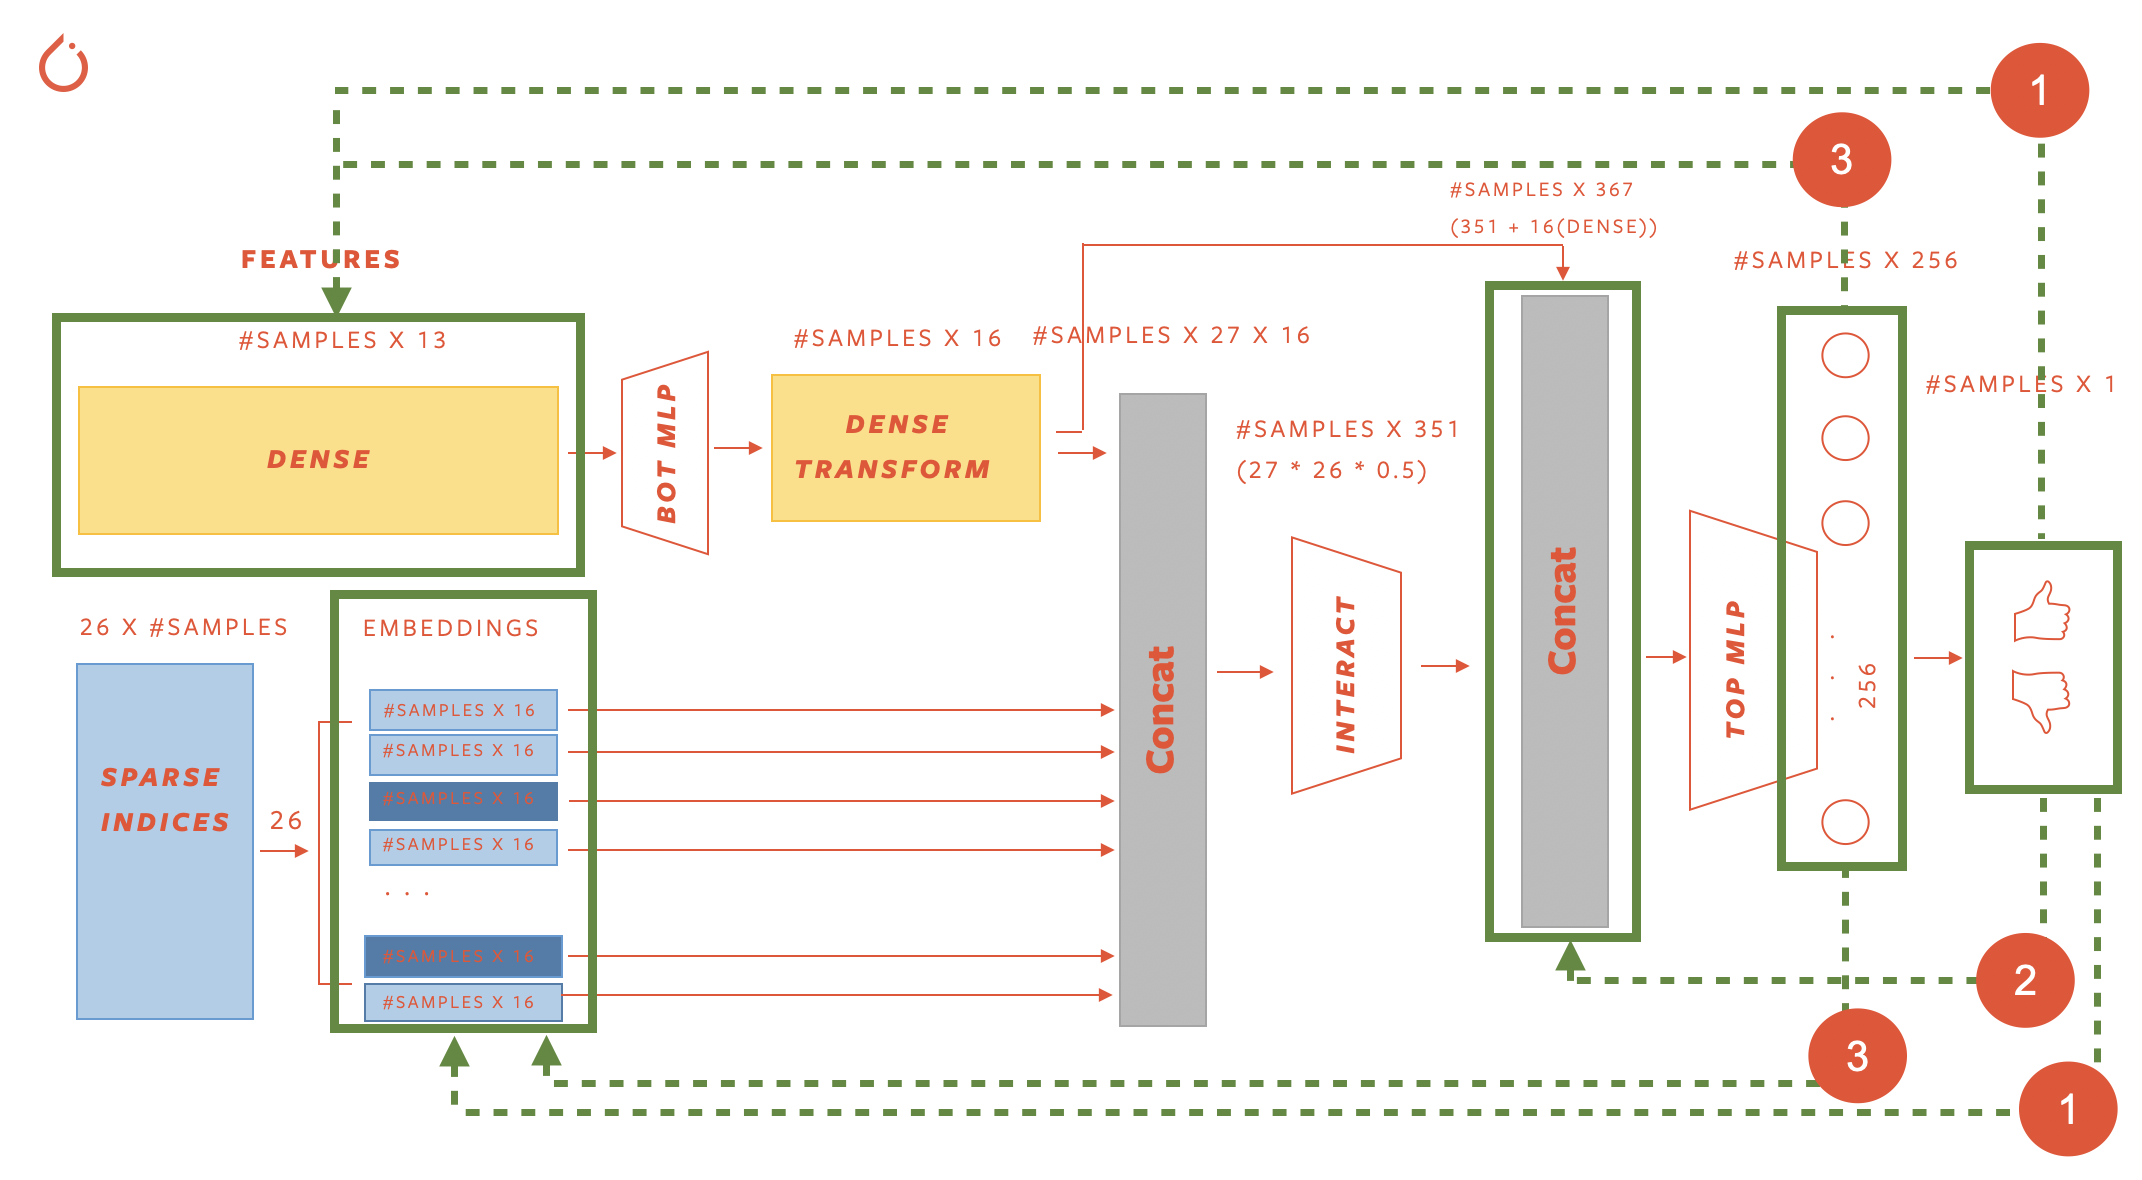

In [1]:
import IPython

IPython.display.Image(filename='img/dlrm_arch.png')


In [2]:
import os, sys
import numpy as np

import torch

# Replace this path with the repo of DLRM project <PATH-TO-DLRM-REPO>
sys.path.insert(0, '<PATH-TO-DLRM-REPO>')

from dlrm_s_pytorch import DLRM_Net

from captum.attr import IntegratedGradients, LayerConductance, NeuronConductance

import matplotlib.pyplot as plt


Defining the device used to store the model and the tensors.

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


Initializing an instance of `DLRM_Net` model and defining parameters necessary to load pretrained DLRM model.

In [4]:
m_spa=16
ln_emb=np.array([1460,583,10131227,2202608,305,24,12517,633,3,93145,5683,8351593,3194,27,14992,5461306,10,5652,2173,4,7046547,18,15,286181,105,142572])
ln_bot=np.array([13,512,256,64,16])
ln_top=np.array([367,512,256,1])

dlrm = DLRM_Net(
            m_spa,
            ln_emb,
            ln_bot,
            ln_top,
            arch_interaction_op="dot",
            arch_interaction_itself=False,
            sigmoid_bot=-1,
            sigmoid_top=ln_top.size - 2,
            sync_dense_params=True,
            loss_threshold=0.0,
            ndevices=-1,
            qr_flag=False,
            qr_operation=None,
            qr_collisions=None,
            qr_threshold=None,
            md_flag=False,
            md_threshold=None,
        )

Loading pre-trained DLRM model and moving it to predefined device.

In [5]:
model_path = 'models/kg.pt'
ld_model = torch.load(model_path)

dlrm.load_state_dict(ld_model["state_dict"])
dlrm = dlrm.to(device)


Since the actual test dataset is pretty large and requires pre-processing, we preprocessed a small portion of it and stored as batches in two 'pt' files so that it is easy for us to work with them. The first 'pt' file, `X_S_T_test_above_0999`, contains 497 samples that are predicted as `Clicked` Ads with a high prediction score, larger than 0.999. The second 'pt' file, X_S_T_test, contains, 1100 samples, Ads, that aren't conditioned on the prediction scores.

The reason why we separated the samples in two groups is that in our analysis we often want to understand most salient features for the Ads that are predicted as `Clicked` with a high prediction score, close to 1.0, vs to the Ads that have mixed prediction scores (some are high and some low).

Below, we load both files, so that we can perform model interpretabily for those pre-processed subsets of data.

In [6]:
S_T_Z_test_above_0999 = torch.load('data/dlrm/X_S_T_test_above_0999')
S_T_Z_test = torch.load('data/dlrm/X_S_T_test')

Re-defining forwad pass for the DLRM model so that it accepts sparse embeddings instead of feature indices and offsets. This is done this way because `apply_emb` cannot be easily replaced by model hooks. https://github.com/facebookresearch/dlrm/blob/52b77f80a24303294a02c86b574529cdc420aac5/dlrm_s_pytorch.py#L276 

In [7]:
def sequential_forward(dense_x, *sparse_y):
    x = dlrm.apply_mlp(dense_x, dlrm.bot_l)
    ly = list(sparse_y)

    # interact features (dense and sparse)
    z = dlrm.interact_features(x, ly)
        
    # obtain probability of a click (using top mlp)
    p = dlrm.apply_mlp(z, dlrm.top_l)
        
    # clamp output if needed
    if 0.0 < dlrm.loss_threshold and dlrm.loss_threshold < 1.0:
        z = torch.clamp(p, min=dlrm.loss_threshold, max=(1.0 - dlrm.loss_threshold))
    else:
        z = p   
                    
    return z
    

Let's extract individual features for each sample from both batches of data. Each sample is represented through dense and sparse features. In this example `X_test` represents dense features. `lS_o_test` and `lS_i_test` represent sparse features. `lS_o_test` represents the offset of each sparse feature group and `lS_i_test` the index. More details about it can be found here: https://github.com/facebookresearch/dlrm/blob/52b77f80a24303294a02c86b574529cdc420aac5/dlrm_s_pytorch.py#L276


In [8]:
X_test_above_0999 = S_T_Z_test_above_0999['X_test'].to(device)
lS_o_test_above_0999 = S_T_Z_test_above_0999['lS_o_test'].to(device)
lS_i_test_above_0999 = S_T_Z_test_above_0999['lS_i_test'].to(device)
probs_above_0999 = S_T_Z_test_above_0999['probs'].to(device)


In [9]:
X_test = S_T_Z_test['X_test'].to(device)
lS_o_test = S_T_Z_test['lS_o_test'].to(device)
lS_i_test = S_T_Z_test['lS_i_test'].to(device)
probs = S_T_Z_test['probs'].to(device)


# Feature Importance

We used one of the sample-based feature importance algorithms, namely Integrated Gradients, in order to understand which features are important in predicting Ads as `Clicked` with high prediction scores. 

In [10]:
ig = IntegratedGradients(sequential_forward)

Below we compute feature importances both for dense and sparse features. We performed the computations both for the batch that contains Ads that are predicted as `Clicked` with high prediction score and the batch that doesn't set any conditions on the prediction score.

In [11]:
embeddings = dlrm.apply_emb(lS_o_test, lS_i_test, dlrm.emb_l)

attributions, delta = ig.attribute((X_test, *embeddings), n_steps=10, return_convergence_delta=True)
attr_dense = attributions[0]
attr_sparse = torch.stack(attributions[1:], dim=1)

# ...... the batch that contains Ads that are predicted as Clicked with high prediction score ......
embeddings_above_0999 = dlrm.apply_emb(lS_o_test_above_0999, lS_i_test_above_0999, dlrm.emb_l)

attributions_above_0999, delta_above_0999 = ig.attribute((X_test_above_0999, *embeddings_above_0999), \
                                                          n_steps=10, return_convergence_delta=True)
attr_dense_above_0999 = attributions_above_0999[0]
attr_sparse_above_0999 = torch.stack(attributions_above_0999[1:], dim=1)


Defining labels / names for dense and sparse features.

In [12]:
dense_names = ['d{}'.format(i) for i in range(attr_dense.shape[1])]
sparse_names = ['s{}'.format(i) for i in range(attr_sparse.shape[1])]

names = dense_names + sparse_names

Below we visualize feature importance scores for 5 different Ads, color-coded in 5 different colors that were predicted as `Clicked` with 0.999 prediction score. X-axis corresponds to the input features and y to the attribution scores. The first 13 features correspond to dense and the last 26 to sparse features. As we can see, the sparse features primarily contribute to `Clicked` predictions whereas dense, contribute to both `Clicked` and `Non-Clicked`.

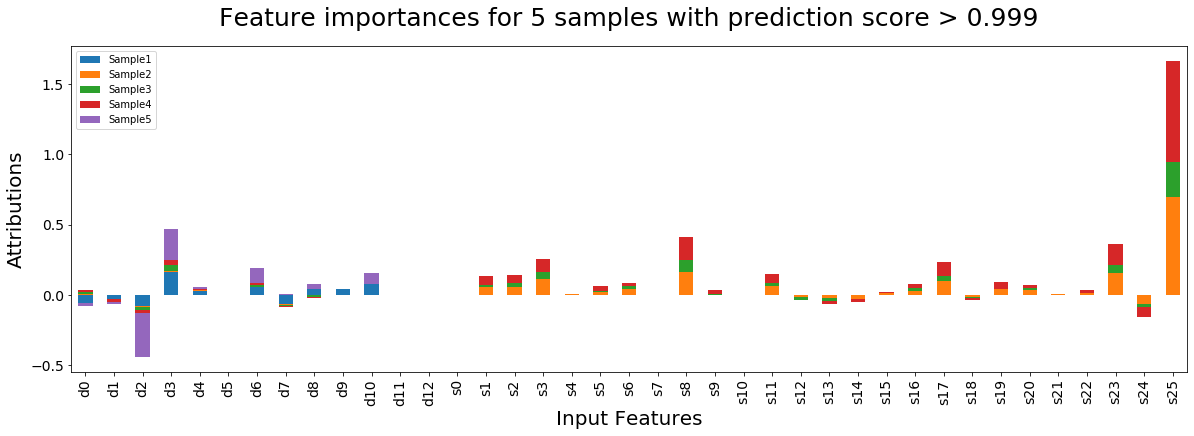

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

parameters = {'figure.figsize': (20, 6),
              'axes.labelsize': 25,
              'axes.titlesize': 25,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14}

plt.rcParams.update(parameters)

# Sample-based interpretability
def sample_features(idx):
    return torch.cat([attr_dense_above_0999[idx, :], \
                      attr_sparse_above_0999[idx, :, :].sum(axis=1)], axis=0).cpu().detach().numpy()


f0 = sample_features(0)
f1 = sample_features(1)
f2 = sample_features(2)
f3 = sample_features(3)
f4 = sample_features(4)

samples_df = pd.DataFrame(index=dense_names + sparse_names,
                          data={'Sample1': f0,
                                'Sample2': f1,
                                'Sample3': f2,
                                'Sample4': f3,
                                'Sample5': f4,
                          })
ax = samples_df.plot(kind="bar", stacked=True)
plt.xlabel('Input Features', fontsize=20)
plt.ylabel('Attributions', fontsize=20)
plt.title('Feature importances for 5 samples with prediction score > 0.999', pad=20)

plt.show()

A helper function to plot aggregated feature importance.

In [14]:
def plot_fi(fi_scores, title, x_axis='Input Features', \
            x_axis_labels=dense_names + sparse_names, y_axis='Attribution'):
    plt.rcParams["figure.figsize"] = (22,4)
    plt.bar(x_axis_labels, fi_scores.detach().cpu().numpy())

    plt.xlabel(x_axis, fontsize=20, labelpad=20)
    plt.ylabel(y_axis, fontsize=20, labelpad=20)

    plt.title(title, pad=20)

    plt.show()

Below we plot aggregated feature importance scores across all 497 samples that have a prediction score close to 1.0.
We can see that the primary and consistent high predictive signal is coming from the sparse features. Dense features contribute to both `Clicked` and `Non-Clicked` predictions.

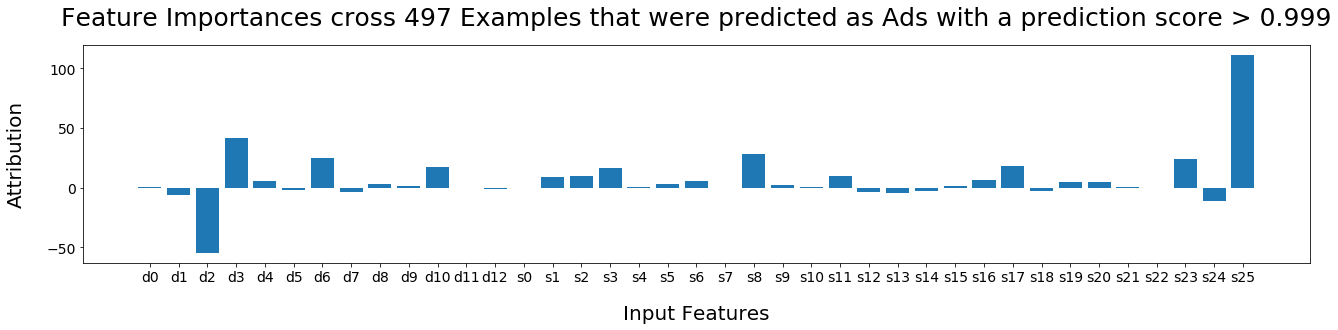

In [15]:
all_features_above_0999 = torch.cat([attr_dense_above_0999.sum(dim=0), attr_sparse_above_0999.sum(dim=(0,2))])
plot_fi(all_features_above_0999, 'Feature Importances cross {} Examples that were predicted as Ads with a ' \
        'prediction score > 0.999'.format(len(probs_above_0999)))


In this example, instead of taking samples with the high prediction score let's consider all samples in `S_T_Z_test` batch. We can clearly see that the relative contribution score for the sparse features reduces and the dense features became significantly prominent which speaks to the fact that the primary signal for `Non-Clicked` is coming from the dense features.

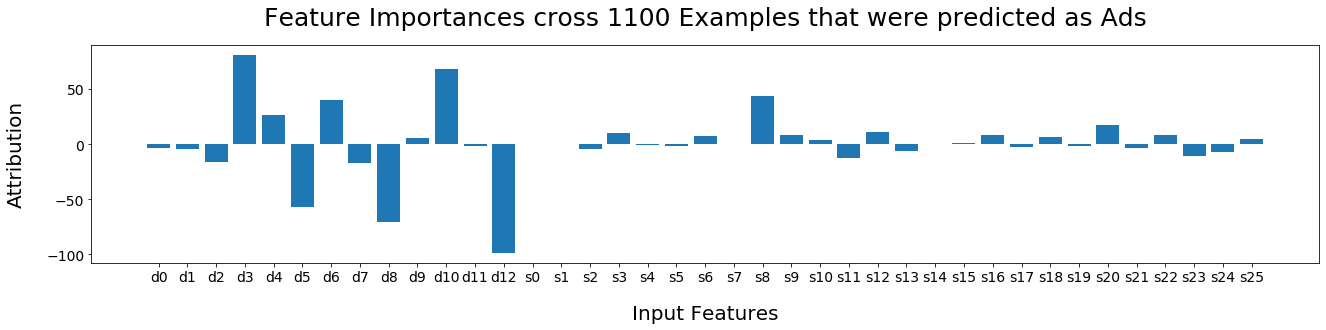

In [16]:
all_features = torch.cat([attr_dense.sum(dim=0), attr_sparse.sum(dim=(0,2))])
plot_fi(all_features, 'Feature Importances cross {} Examples that were predicted as Ads'.format(len(probs)))


# Interaction Layer Importance

Now let’s look deeper into the interaction layer. More specifically, let’s examine how important, pairwise feature interactions in the output of the interaction layer, are. In the interaction layer we consider interactions between 27 16-dimensional feature representations, 26 corresponding to sparse and 1 to dense features. The last 16-dimensional dense representation is emerged after transforming 13 dense features into one 16-dimensional embedding vector. In the interaction layer we consider pairwise interactions of 27 features using dot products. This results to 27 * 26 * 0.5 = 351 pairwise interactions excluding self interactions. In the very end, 16-dimensional dense feature representation is being prepended to resulting interactions leading to 16 + 351 = 367 neurons in the output of second concatenation layer.

We use Layer Conductance algorithm to estimate the importance of all 367 neurons. 

In [17]:
lc = LayerConductance(sequential_forward, dlrm.top_l)


In [18]:
layer_attribution = lc.attribute(inputs=(X_test_above_0999, *embeddings_above_0999),
                                              n_steps=10,
                                              attribute_to_layer_input=True)

The figure below demonstrates the importance scores of each neuron in the output of interaction layer. First 16 neurons have mixed contributions both to `Clicked` and `Non-Clicked` predictions. The following 351 interaction neurons either primarily contribute to `Clicked` or have no effect on the prediction. In fact we can see that many of those interactions have no affect on the prediction. This observations, however, are supported by 497 samples that are predicted as `Clicked` with a prediction score larger than 0.999. One might think that the samples might not be representative enough, however, even if we increase the sample size we still observe similar patterns. As an extension of this work one might think of performing statistical significance testing for random subsamples that are predicted as clicked with high prediction score to make more convincing statements.


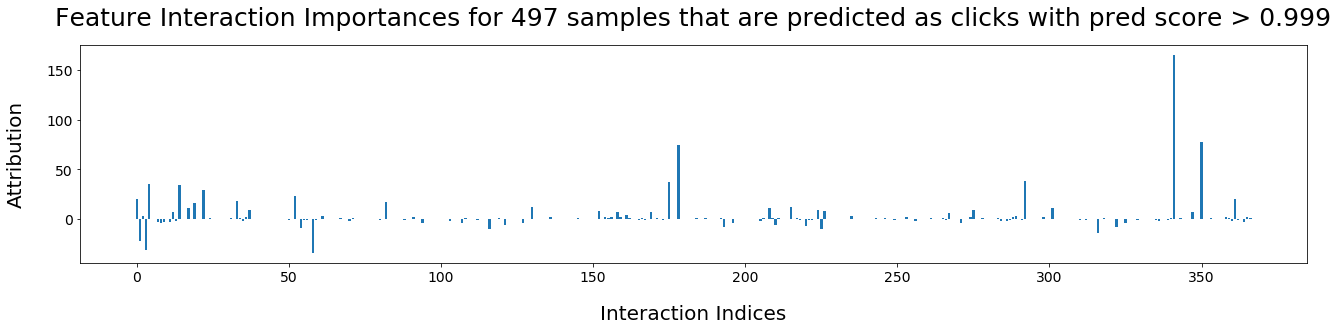

In [19]:
layer_attrs_all_sum = layer_attribution.sum(axis=0)

plot_fi(layer_attrs_all_sum, \
        title='Feature Interaction Importances for {} samples that are predicted ' \
        'as clicks with pred score > 0.999'.format(len(layer_attribution)),
        x_axis='Interaction Indices',
        x_axis_labels=list(range(len(layer_attrs_all_sum)))
       )

# Neuron Importance

In the last experiment we look into the aggregated attribution scores stacked for 82 Ads that were predicted as `Clicked` with prediction score > 0.6 for all 256 neurons in the last fully connected layer.

For our experiments we used NeuronConductance algorithm.

In [20]:
nc = NeuronConductance(sequential_forward, dlrm.top_l[3])

On figure below we visualize stacked attribution score per neuron, considering that the attribution scores can be both positive and negative. When we analyze resulting neuron importances, we conclude that 36 out of 256 neurons are always assigned a negative and another 13 are always assigned zero attribution scores according to all 82 Ads samples with prediction score > 0.6. The remaining neurons are assigned either positive or mixed (positive, zero or negative) attribution scores.

In [21]:
indices = (probs.squeeze() > 0.6).nonzero().view(-1)

data = []

for neuron_index in range(256):
    neuron_attributions = nc.attribute(inputs=(X_test, *embeddings),
                                        neuron_index=neuron_index, n_steps=10)
    neuron_attributions_dense = torch.index_select(neuron_attributions[0], 0, indices) #take first 100 samples for visualization purposes
    neuron_attributions_sparse = torch.index_select(torch.stack(neuron_attributions[1:], axis=1), 0, indices)
    all_features = torch.cat([neuron_attributions_dense,
                              neuron_attributions_sparse.sum(axis=1)],
                              axis=1).sum(axis=1).cpu().detach().numpy()
    data.append(all_features)


In [25]:
data = np.array(data)

header = dense_names + sparse_names
all_neurons = pd.DataFrame(data)
all_neurons.plot(kind="barh", stacked=True, mark_right=True, legend=False)
plt.rcParams["figure.figsize"] = (200,200)
plt.xlabel('Accumulated Attributions', fontsize=40)
plt.ylabel('Neuron Indices', fontsize=40)


Text(0, 0.5, 'Neuron Indices')

The list of all neurons that had zero contribution in predicting that an Ad is `Clicked`out of all 82 samples.

In [23]:
zero_contributions = sum((all_neurons != 0.0).sum(axis=1) == 0.0)
zero_contributions

13

The list of all neurons that have negative contributions in predicting that an Ad is Clicked out of all 82 samples.

In [24]:
negative_contributions = sum((all_neurons > 0.0).sum(axis=1) == 0.0) - zero_contributions
negative_contributions

36

# Model pruning based on neuron importance

We can extend our analysis further and ablate the neurons that have zero contribution to the prediction or are negatively correlated with the ads prediction across all samples. According to the specific examples demonstrated above we can see that based on our sample size of 82(prediction score > 0.6), 13 neurons out of all 256 always demonstrate zero contribution to the prediction. If we ablate this neurons we can see that the False Negatives are reducing and overall Recall and F1 score of the model are increasing. Since this is a tutorial and measuring the accuracy and F1 scores on test data can be time consuming we do not demonstrate it here but the users are welcome to ablate those neurons based on the neuron importance scores and examine the difference in the Accurancy and F1 scores.

Similar thinking can also be applied to the neurons that are always negatively correlated with the `Clicked` prediction.